# Setup 

## Imports

In [112]:
import pandas as pd
import numpy as np
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Tuple

from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)



## Configs e paths

In [113]:
FEATURE_DIR   = Path("../data/features/hmog_None")
RESULT_DIR    = Path("../data/results/svm")
SEED          = 42
SENSOR        = 'gyroscope'

feature_cols = { "accelerometer":
    [
        'acc_x_mean', 'acc_x_median', 'acc_x_std', 'acc_x_min', 'acc_x_max',
        'acc_y_mean', 'acc_y_median', 'acc_y_std', 'acc_y_min', 'acc_y_max',
        'acc_z_mean', 'acc_z_median', 'acc_z_std', 'acc_z_min', 'acc_z_max',
        'magnitude_mean', 'magnitude_std', 'magnitude_min', 'magnitude_max',
        'corr_xz', 'corr_yz'
    ],
    "gyroscope":
    [
        'gyro_x_mean', 'gyro_x_median', 'gyro_x_std', 'gyro_x_min', 'gyro_x_max',
        'gyro_y_mean', 'gyro_y_median', 'gyro_y_std', 'gyro_y_min', 'gyro_y_max',
        'gyro_z_mean', 'gyro_z_median', 'gyro_z_std', 'gyro_z_min', 'gyro_z_max',
        'magnitude_mean', 'magnitude_std', 'magnitude_min', 'magnitude_max',
        'corr_xz', 'corr_yz'
    ]
}
drop_cols = {"accelerometer": ['acc_x_skewness', 'acc_x_kurtosis','acc_y_skewness', 'acc_y_kurtosis',
                                'acc_z_skewness', 'acc_z_kurtosis','magnitude_skewness', 'magnitude_kurtosis'],
            "gyroscope": ['gyro_x_skewness', 'gyro_x_kurtosis','gyro_y_skewness', 'gyro_y_kurtosis',
                                'gyro_z_skewness', 'gyro_z_kurtosis','magnitude_skewness', 'magnitude_kurtosis']
        }


In [114]:
pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="linear", class_weight="balanced", probability=False, random_state=SEED)),
])
param_grid = {
    'svc__C': [0.1, 1, 10]
}

## Util functions

In [115]:
def compute_metrics(y_true: np.ndarray, scores: np.ndarray) -> Dict[str, float]:
    # --- EER / TAR ---
    fpr, tpr, thr = roc_curve(y_true, scores)
    fnr = 1 - tpr
    idx = np.nanargmin(np.abs(fpr - fnr))
    eer = (fpr[idx] + fnr[idx]) / 2
    tar = tpr[idx]

    # --- AUC e Average-Precision ---
    auc  = roc_auc_score(y_true, scores)
    ap   = average_precision_score(y_true, scores)

    # --- FPR @ 95 % TPR (ou o mais perto possível) ---
    tpr_target = 0.95
    idx95 = np.nanargmin(np.abs(tpr - tpr_target))
    fpr95 = fpr[idx95]

    return {
        "EER": eer,
        "TAR": tar,
        "AUC": auc,
        "AP": ap,
        "FPR95_TPR": fpr95,
        "fpr": fpr.astype(np.float32),
        "tpr": tpr.astype(np.float32),
    }

## Main

### Load dataframe

In [116]:
df = pd.read_parquet(FEATURE_DIR / f"{SENSOR}_features.parquet")
df = df.drop(columns=drop_cols.get(SENSOR, []))

### Dataframe Info

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2451754 entries, 0 to 2451753
Data columns (total 26 columns):
 #   Column          Dtype  
---  ------          -----  
 0   sensor          object 
 1   subject_id      object 
 2   session_number  int64  
 3   start_ms        int64  
 4   end_ms          int64  
 5   gyro_x_mean     float64
 6   gyro_x_median   float64
 7   gyro_x_std      float64
 8   gyro_x_min      float64
 9   gyro_x_max      float64
 10  gyro_y_mean     float64
 11  gyro_y_median   float64
 12  gyro_y_std      float64
 13  gyro_y_min      float64
 14  gyro_y_max      float64
 15  gyro_z_mean     float64
 16  gyro_z_median   float64
 17  gyro_z_std      float64
 18  gyro_z_min      float64
 19  gyro_z_max      float64
 20  magnitude_mean  float64
 21  magnitude_std   float64
 22  magnitude_min   float64
 23  magnitude_max   float64
 24  corr_xz         float64
 25  corr_yz         float64
dtypes: float64(21), int64(3), object(2)
memory usage: 486.3+ MB


### User picking

In [118]:
users = df['subject_id'].unique()
rng = np.random.default_rng(SEED)
user = rng.choice(users, 1)[0]

print(f"Selected user: {user}")

results = {}

Selected user: 220962


### Train

In [119]:
user_df = df.copy()
user_df['label'] = (user_df['subject_id'] == user).astype(int)
sessions = user_df.loc[user_df['label'] == 1, 'session_number'].unique()
user_results = []

In [120]:
for test_session in sessions[0:24]: # limitado a 10 sessoes
    train_mask = user_df['session_number'] != test_session
    test_mask = user_df['session_number'] == test_session

    X_train_full = user_df.loc[train_mask, feature_cols.get(SENSOR, [])]
    y_train_full = user_df.loc[train_mask, 'label']

    ## Cria subamostragem de impostores 
    pos_idx = y_train_full[y_train_full == 1].index
    neg_idx = y_train_full[y_train_full == 0].index
    n_pos = len(pos_idx)
    n_neg_sample = min(len(neg_idx), n_pos * 2) # 2x impostores
    neg_sample_idx = np.random.RandomState(SEED).choice(neg_idx, size=n_neg_sample, replace=False) 
    
    selected_idx = np.concatenate([pos_idx, neg_sample_idx])

    max_samples = 10000
    if len(selected_idx) > max_samples:
        selected_idx = np.random.RandomState(SEED).choice(selected_idx, size=max_samples, replace=False)
    
    X_train = X_train_full.loc[selected_idx]
    y_train = y_train_full.loc[selected_idx]

    X_test = user_df.loc[test_mask, feature_cols.get(SENSOR, [])]
    y_test = user_df.loc[test_mask, 'label']

    mask = X_test.notna().all(axis=1)
    X_test = X_test.loc[mask]
    y_test = y_test.loc[mask]

    print(f"\nUsuário {user} - Sessão {test_session}")
    print(f" Treino original: {X_train_full.shape[0]} (pos={sum(y_train_full)}, neg={len(y_train_full)-sum(y_train_full)})")
    print(f" Treino subamostrado limitado a {max_samples} amostras: (pos={sum(y_train)}, neg={len(y_train)-sum(y_train)})")
    #print(f" Teste: {X_test.shape[0]} (pos={sum(y_test)}, neg={len(y_test)-sum(y_test)})")
    
    cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
    grid = GridSearchCV(pipe, param_grid, cv=cv_inner, scoring='roc_auc', n_jobs=-1)
    t0 = time.perf_counter()
    grid.fit(X_train, y_train)
    t1 = time.perf_counter()
    train_time = t1 - t0
    print(f" Treinamento concluído em {train_time:.2f} segundos")

    y_score = grid.decision_function(X_test)
    metrics = compute_metrics(y_test, y_score)

    user_results.append(
        {
        'sensor': SENSOR,
        'session': test_session,
        'best_C': grid.best_params_['svc__C'],
        "n_support_vectors": int(grid.best_estimator_.named_steps["svc"].n_support_.sum()),
        "train_time_sec": train_time,
        "n_pos_train": int((y_train==1).sum()),
        "n_neg_train": int((y_train==0).sum()),
        "n_pos_test":  int((y_test==1).sum()),
        "n_neg_test":  int((y_test==0).sum()),
        
        **metrics
        }
    )

results[user] = pd.DataFrame(user_results)


Usuário 220962 - Sessão 1
 Treino original: 2325101 (pos=22697, neg=2302404)
 Treino subamostrado limitado a 10000 amostras: (pos=3304, neg=6696)
 Treinamento concluído em 17.81 segundos

Usuário 220962 - Sessão 2
 Treino original: 2324670 (pos=22859, neg=2301811)
 Treino subamostrado limitado a 10000 amostras: (pos=3370, neg=6630)
 Treinamento concluído em 21.15 segundos

Usuário 220962 - Sessão 3
 Treino original: 2345433 (pos=23329, neg=2322104)
 Treino subamostrado limitado a 10000 amostras: (pos=3321, neg=6679)
 Treinamento concluído em 20.89 segundos

Usuário 220962 - Sessão 4
 Treino original: 2331995 (pos=23216, neg=2308779)
 Treino subamostrado limitado a 10000 amostras: (pos=3299, neg=6701)
 Treinamento concluído em 19.22 segundos

Usuário 220962 - Sessão 5
 Treino original: 2348073 (pos=23493, neg=2324580)
 Treino subamostrado limitado a 10000 amostras: (pos=3324, neg=6676)
 Treinamento concluído em 13.03 segundos

Usuário 220962 - Sessão 6
 Treino original: 2348695 (pos=22

### Results

In [121]:
print(f"Resultados para usuário {user}:")
print(results[user])
df_results = pd.DataFrame(results[user])
df_results.to_parquet(
    Path(RESULT_DIR / f"{user}_{SENSOR}_verification_results.parquet"),
    index=False,
)

Resultados para usuário 220962:
       sensor  session  best_C  n_support_vectors  train_time_sec  \
0   gyroscope        1       1               8305       17.807481   
1   gyroscope        2      10               8324       21.149641   
2   gyroscope        3      10               8398       20.888649   
3   gyroscope        4      10               8350       19.222499   
4   gyroscope        5       1               8317       13.026298   
5   gyroscope        6       1               8344       14.177112   
6   gyroscope        7      10               8225       19.266428   
7   gyroscope        8      10               8232       18.956803   
8   gyroscope        9      10               8326       20.019644   
9   gyroscope       10       1               8257       13.815751   
10  gyroscope       11       1               8546       13.340377   
11  gyroscope       12      10               8414       18.907353   
12  gyroscope       13      10               8219       21.226119   
13

<Axes: title={'center': 'EER'}, xlabel='sensor'>

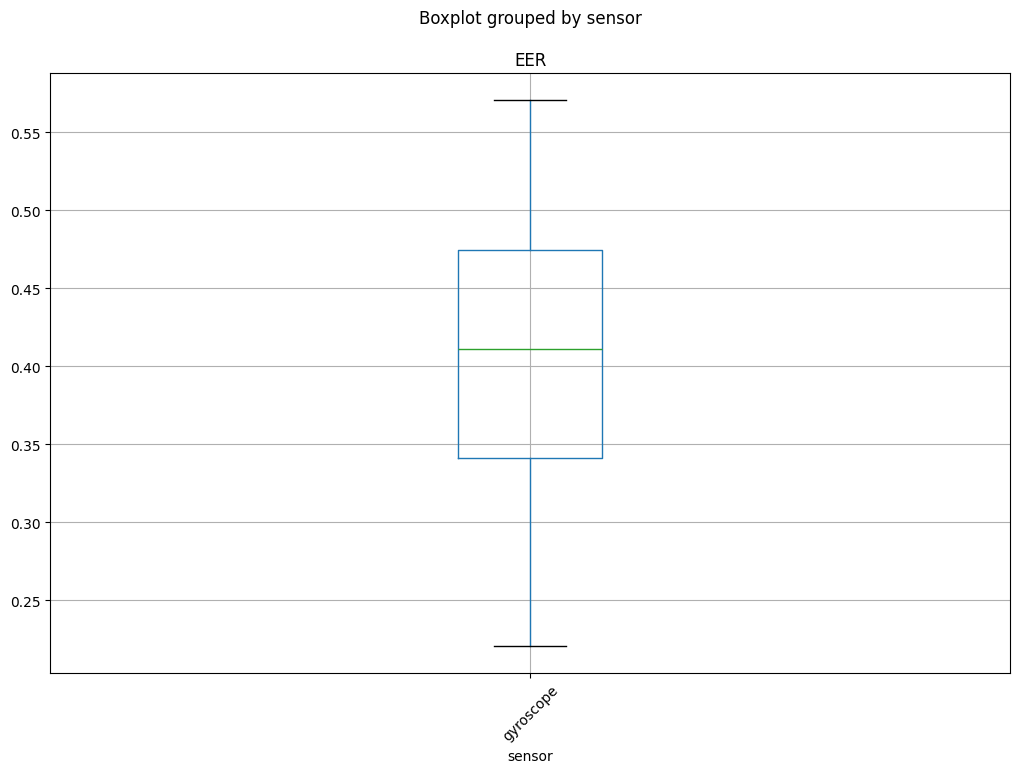

In [122]:
df_results.boxplot(
    column=['EER'],
    by='sensor',
    figsize=(12, 8),
    rot=45,
)

<Axes: xlabel='train_time_sec', ylabel='EER'>

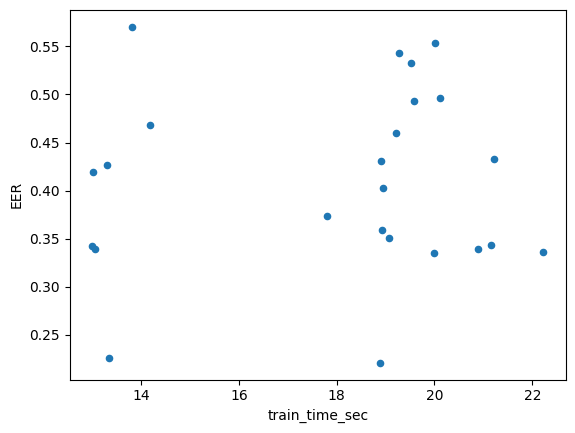

In [123]:
df_results.plot.scatter(
    x='train_time_sec',
    y='EER'
)